In [68]:
# open the generated synthetic data file and read it as a python dictionary called data

import json

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

file = open('synthetic_dataset_with_time.txt', 'r')
text = file.read()
data = json.loads(text)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
import emip_toolkit as EMTK

# find areas of interest (AOIs) once again
image_path = "./"
image = "synthetic_text.png"
aoi = EMTK.find_aoi(image, image_path, level="sub-line")


# add tokens to AOIs 
file_path = "./"
aois_with_tokens = EMTK.add_tokens_to_AOIs(file_path, image.split(".")[0]+".txt", aoi)
aois_with_tokens.head()


import correction

# find the y coordinate of each line in the text
line_ys = correction.find_lines_Y(aoi)

/Users/jonnasosauranga/Desktop/CS421-project1/emip_toolkit.py:1255: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aoi = aoi.append(dic, ignore_index=True)
/Users/jonnasosauranga/Desktop/CS421-project1/emip_toolkit.py:1255: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aoi = aoi.append(dic, ignore_index=True)
/Users/jonnasosauranga/Desktop/CS421-project1/emip_toolkit.py:1255: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aoi = aoi.append(dic, ignore_index=True)
/Users/jonnasosauranga/Desktop/CS421-project1/emip_toolkit.py:1255: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aoi = aoi.append(dic, ignore_index=True)
/Users/jonnasosauranga/D

In [70]:
import numpy as np
import drift_algorithms as algo
from tqdm import tqdm

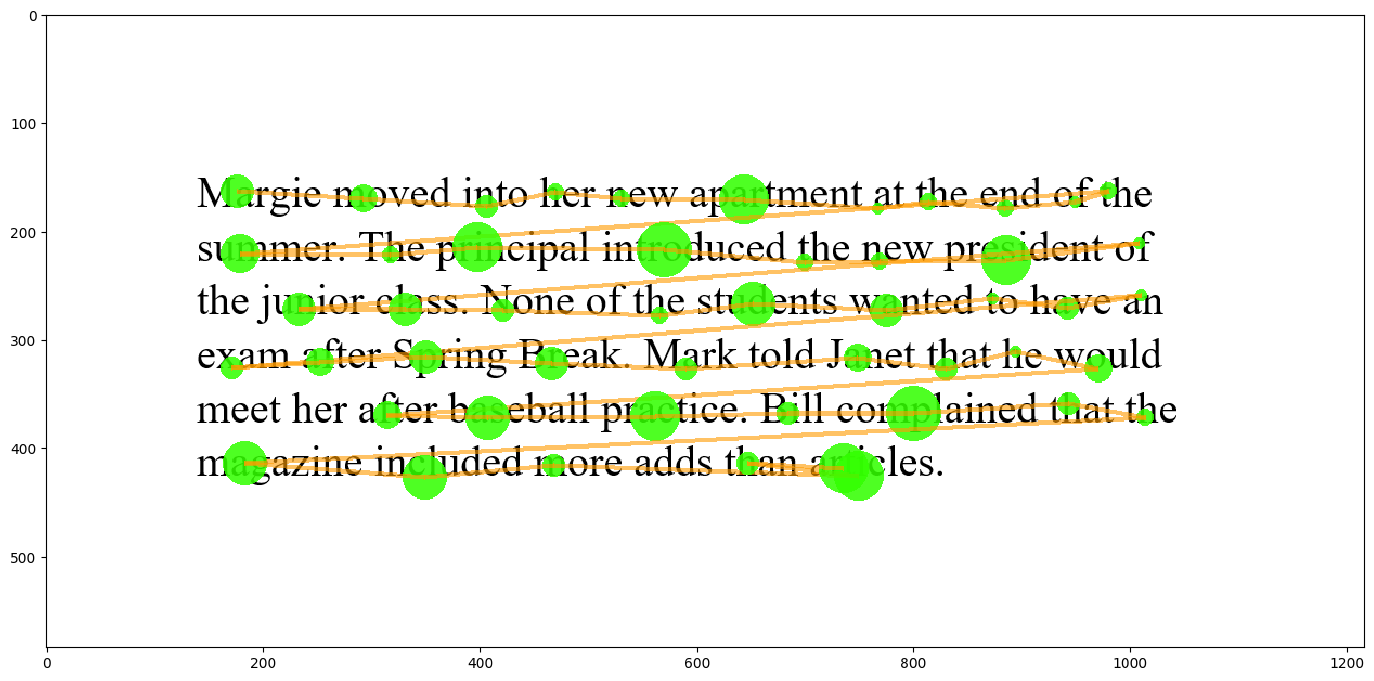

In [71]:
# draw original correct fixations

correction.draw_fixation('synthetic_text.png', data['robot1'].copy())

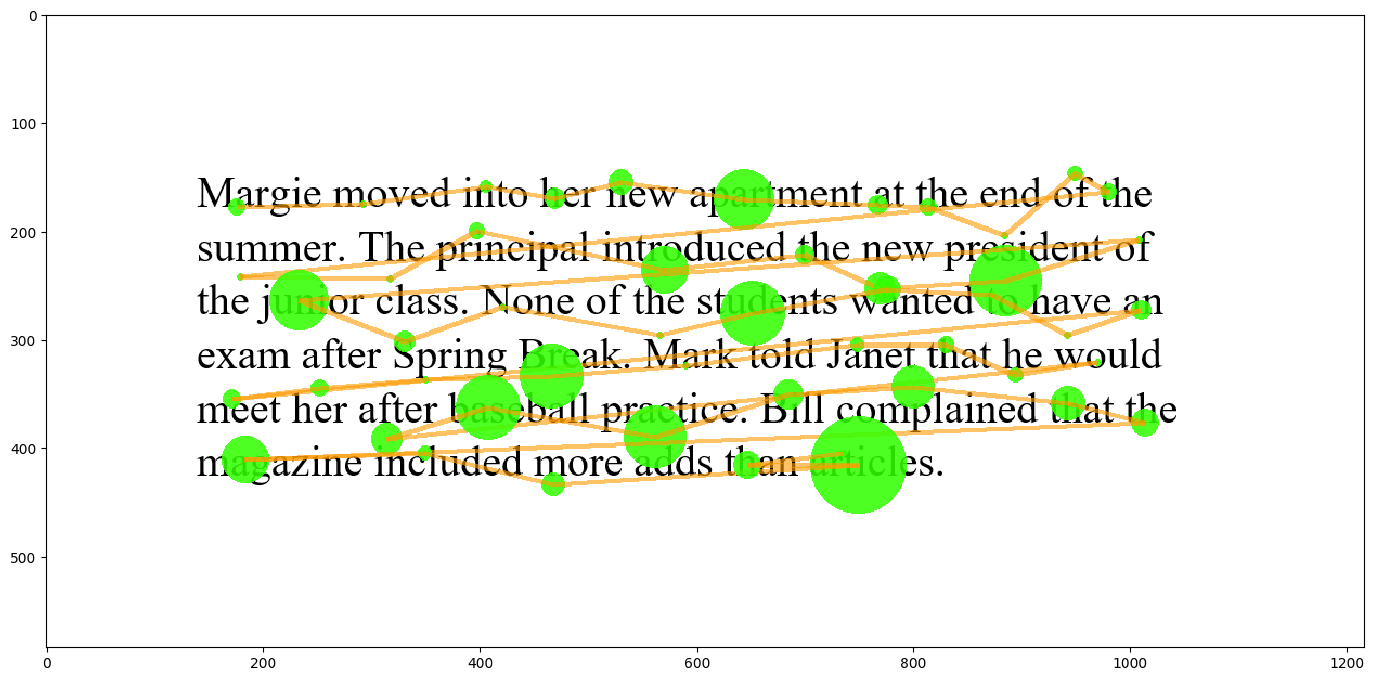

In [72]:
# generate noise over the correct trial

error_test = correction.error_noise(1, 30, 1, data['robot1'].copy())

# draw the trial with added error
correction.draw_fixation('synthetic_text.png', error_test)

1.0


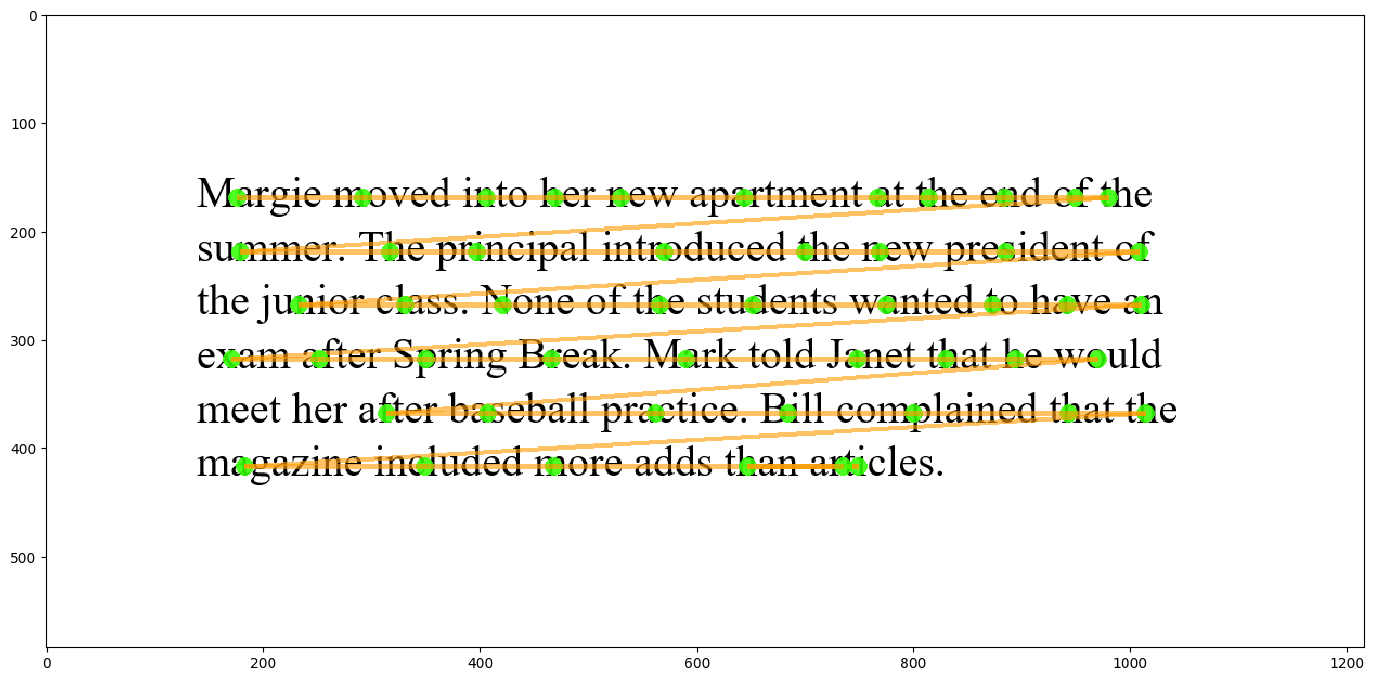

In [73]:
# find the center of each word, we need this for warp algorithm
word_centers = correction.find_word_centers(aoi)
word_centers = np.array(word_centers.copy(), dtype=int)

# warp correction
np_array = np.array(error_test.copy(), dtype=int)
durations = np.delete(np_array, 0, 1)
durations = np.delete(durations, 0, 1)
np_array = np.delete(np_array, 2, 1)

# run warp
warp_correction = algo.warp(np_array, word_centers)

# this is a cool function that checks the quality of the correction
percentage, match_list = correction.correction_quality(aoi, data['robot1'].copy(), warp_correction)
print(percentage)

# this is a cool function that draws the correction in red if the algorithm made a mistake
correction.draw_correction('synthetic_text.png', warp_correction, match_list)

This concludes the example I wanted to show you of running an error generator, then correcting the data, then seeing how well the correction algorithm did.  You will need to repeat the same concept for a bunch of algorithms in the next section.

# Comparing algorithms with Noise error:

In this example, I show you one type of erro "Noise" you will implement all 5 types and add skipping to your assessment.  Also, the code below runs only 4 algorithms, you will add the remaining 6 algorithms to this assessment for each type of error. 

In [110]:
import random
print(random.randint(1,2))

1


In [113]:
import my_refactor as r

attach_results = [[],[],[],[],[],[],[],[],[],[],[]]
chain_results = [[],[],[],[],[],[],[],[],[],[],[]]
regress_results = [[],[],[],[],[],[],[],[],[],[],[]]
warp_results = [[],[],[],[],[],[],[],[],[],[],[]]
cluster_results = [[],[],[],[],[],[],[],[],[],[],[]]
compare_results = [[],[],[],[],[],[],[],[],[],[],[]]
merge_results = [[],[],[],[],[],[],[],[],[],[],[]]
segment_results = [[],[],[],[],[],[],[],[],[],[],[]]
split_results = [[],[],[],[],[],[],[],[],[],[],[]]
stretch_results = [[],[],[],[],[],[],[],[],[],[],[]]

word_centers = correction.find_word_centers(aoi)
word_centers = np.array(word_centers.copy(), dtype=int)

duration_word_centers = correction.find_word_centers_and_duration(aois_with_tokens)
duration_word_centers = np.array(duration_word_centers.copy(), dtype=int)

# MAKE SURE YOU RUN THIS 100 TIMES, NOT JUST ONE!!!
for robot_index in tqdm(range(100)):#1 is for one robot
    print('robot ' + str(robot_index))
    
    for error_probability in range(0, 11):
        # generate error
        error_test = correction.error_noise(error_probability/10, 30, error_probability/10, data['robot' + str(robot_index)].copy())

        # attach correction
        percentage, corrections, match_list = r.attach_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        attach_results[error_probability].append(percentage)

        # chain correction
        percentage, corrections, match_list = r.chain_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        chain_results[error_probability].append(percentage)
        
        # regress correction
        percentage, corrections, match_list = r.regress_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        regress_results[error_probability].append(percentage)
        
        # warp correction
        percentage, warp_correction, match_list = r.warp_correction(error_test, word_centers, aoi, data['robot' + str(robot_index)])
        warp_results[error_probability].append(percentage)

        # cluster correction
        percentage, corrections, match_list = r.cluster_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        cluster_results[error_probability].append(percentage)

        # compare correction
        percentage, corrections, match_list = r.compare_correction(error_test, line_ys, word_centers, aoi, data['robot' + str(robot_index)])
        compare_results[error_probability].append(percentage)

        # merge correction
        percentage, corrections, match_list = r.merge_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        merge_results[error_probability].append(percentage)

        # segment correction
        percentage, corrections, match_list = r.segment_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        segment_results[error_probability].append(percentage)

        # split correction
        percentage, corrections, match_list = r.split_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        split_results[error_probability].append(percentage)

        # stretch correction
        percentage, corrections, match_list = r.stretch_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        stretch_results[error_probability].append(percentage)

        '''if percentage < 1:
            correction.draw_correction('synthetic_text.png', corrections, match_list)
            print("robot:", robot_index, "    error probability:", error_probability)'''


  0%|          | 0/100 [00:00<?, ?it/s]

robot 0


  1%|          | 1/100 [00:13<21:43, 13.17s/it]

robot 1


  2%|▏         | 2/100 [00:25<20:35, 12.61s/it]

robot 2


  3%|▎         | 3/100 [00:46<26:17, 16.27s/it]

robot 3


  4%|▍         | 4/100 [00:59<24:22, 15.23s/it]

robot 4


  5%|▌         | 5/100 [01:12<22:41, 14.33s/it]

robot 5


  6%|▌         | 6/100 [01:26<22:08, 14.14s/it]

robot 6


  7%|▋         | 7/100 [01:39<21:41, 14.00s/it]

robot 7


  8%|▊         | 8/100 [01:58<23:37, 15.41s/it]

robot 8


  9%|▉         | 9/100 [02:11<22:34, 14.88s/it]

robot 9


 10%|█         | 10/100 [02:29<23:45, 15.84s/it]

robot 10


 11%|█         | 11/100 [02:46<23:58, 16.16s/it]

robot 11


 12%|█▏        | 12/100 [02:59<22:18, 15.21s/it]

robot 12


 13%|█▎        | 13/100 [03:19<23:54, 16.49s/it]

robot 13


 14%|█▍        | 14/100 [03:30<21:31, 15.02s/it]

robot 14


 15%|█▌        | 15/100 [03:44<20:26, 14.43s/it]

robot 15


 16%|█▌        | 16/100 [03:55<18:59, 13.56s/it]

robot 16


 17%|█▋        | 17/100 [04:10<19:27, 14.06s/it]

robot 17


 18%|█▊        | 18/100 [04:23<18:41, 13.67s/it]

robot 18


 19%|█▉        | 19/100 [04:38<18:58, 14.06s/it]

robot 19


 20%|██        | 20/100 [04:52<18:36, 13.95s/it]

robot 20


 21%|██        | 21/100 [05:05<18:09, 13.79s/it]

robot 21


 22%|██▏       | 22/100 [05:20<18:23, 14.15s/it]

robot 22


 23%|██▎       | 23/100 [05:32<17:26, 13.59s/it]

robot 23


 24%|██▍       | 24/100 [05:47<17:36, 13.90s/it]

robot 24


 25%|██▌       | 25/100 [06:00<16:54, 13.53s/it]

robot 25


 26%|██▌       | 26/100 [06:13<16:40, 13.52s/it]

robot 26


 27%|██▋       | 27/100 [06:26<16:22, 13.45s/it]

robot 27


 28%|██▊       | 28/100 [06:38<15:17, 12.75s/it]

robot 28


 29%|██▉       | 29/100 [06:54<16:33, 14.00s/it]

robot 29


 30%|███       | 30/100 [07:06<15:26, 13.23s/it]

robot 30


 31%|███       | 31/100 [07:21<15:48, 13.75s/it]

robot 31


 32%|███▏      | 32/100 [07:43<18:26, 16.27s/it]

robot 32


 33%|███▎      | 33/100 [07:54<16:24, 14.70s/it]

robot 33


 34%|███▍      | 34/100 [08:09<16:14, 14.76s/it]

robot 34


 35%|███▌      | 35/100 [08:22<15:23, 14.21s/it]

robot 35


 36%|███▌      | 36/100 [08:37<15:17, 14.33s/it]

robot 36


 37%|███▋      | 37/100 [08:51<15:09, 14.44s/it]

robot 37


 38%|███▊      | 38/100 [09:06<14:58, 14.49s/it]

robot 38


 39%|███▉      | 39/100 [09:20<14:34, 14.34s/it]

robot 39


 40%|████      | 40/100 [09:32<13:39, 13.66s/it]

robot 40


 41%|████      | 41/100 [09:52<15:12, 15.47s/it]

robot 41


 42%|████▏     | 42/100 [10:08<15:06, 15.63s/it]

robot 42


 43%|████▎     | 43/100 [10:27<15:47, 16.63s/it]

robot 43


 44%|████▍     | 44/100 [10:41<14:51, 15.93s/it]

robot 44


 45%|████▌     | 45/100 [10:56<14:18, 15.60s/it]

robot 45


 46%|████▌     | 46/100 [11:08<13:13, 14.69s/it]

robot 46


 47%|████▋     | 47/100 [11:20<12:09, 13.76s/it]

robot 47


 48%|████▊     | 48/100 [11:30<10:56, 12.62s/it]

robot 48


 49%|████▉     | 49/100 [11:44<11:13, 13.20s/it]

robot 49


 50%|█████     | 50/100 [11:59<11:16, 13.53s/it]

robot 50


 51%|█████     | 51/100 [12:09<10:19, 12.65s/it]

robot 51


 52%|█████▏    | 52/100 [12:23<10:19, 12.90s/it]

robot 52


 53%|█████▎    | 53/100 [12:37<10:20, 13.21s/it]

robot 53


 54%|█████▍    | 54/100 [12:49<09:52, 12.87s/it]

robot 54


 55%|█████▌    | 55/100 [13:06<10:32, 14.06s/it]

robot 55


 56%|█████▌    | 56/100 [13:19<10:11, 13.90s/it]

robot 56


 57%|█████▋    | 57/100 [13:33<09:58, 13.92s/it]

robot 57


 58%|█████▊    | 58/100 [13:48<09:52, 14.12s/it]

robot 58


 59%|█████▉    | 59/100 [13:58<08:50, 12.95s/it]

robot 59


 60%|██████    | 60/100 [14:08<08:05, 12.13s/it]

robot 60


 61%|██████    | 61/100 [14:24<08:31, 13.12s/it]

robot 61


 62%|██████▏   | 62/100 [14:39<08:40, 13.69s/it]

robot 62


 63%|██████▎   | 63/100 [14:53<08:33, 13.87s/it]

robot 63


 64%|██████▍   | 64/100 [15:04<07:49, 13.03s/it]

robot 64


 65%|██████▌   | 65/100 [15:17<07:38, 13.11s/it]

robot 65


 66%|██████▌   | 66/100 [15:29<07:12, 12.73s/it]

robot 66


 67%|██████▋   | 67/100 [15:45<07:30, 13.66s/it]

robot 67


 68%|██████▊   | 68/100 [15:59<07:17, 13.68s/it]

robot 68


 69%|██████▉   | 69/100 [16:11<06:48, 13.18s/it]

robot 69


 70%|███████   | 70/100 [16:24<06:36, 13.23s/it]

robot 70


 71%|███████   | 71/100 [16:38<06:27, 13.37s/it]

robot 71


 72%|███████▏  | 72/100 [16:51<06:11, 13.28s/it]

robot 72


 73%|███████▎  | 73/100 [17:01<05:36, 12.45s/it]

robot 73


 74%|███████▍  | 74/100 [17:12<05:13, 12.07s/it]

robot 74


 75%|███████▌  | 75/100 [17:29<05:32, 13.30s/it]

robot 75


 76%|███████▌  | 76/100 [17:39<05:00, 12.51s/it]

robot 76


 77%|███████▋  | 77/100 [17:52<04:46, 12.48s/it]

robot 77


 78%|███████▊  | 78/100 [18:06<04:48, 13.11s/it]

robot 78


 79%|███████▉  | 79/100 [18:21<04:42, 13.47s/it]

robot 79


 80%|████████  | 80/100 [18:40<05:06, 15.31s/it]

robot 80


 81%|████████  | 81/100 [18:59<05:11, 16.41s/it]

robot 81


 82%|████████▏ | 82/100 [19:13<04:42, 15.67s/it]

robot 82


 83%|████████▎ | 83/100 [19:25<04:09, 14.65s/it]

robot 83


 84%|████████▍ | 84/100 [19:38<03:46, 14.14s/it]

robot 84


 85%|████████▌ | 85/100 [19:48<03:13, 12.92s/it]

robot 85


 86%|████████▌ | 86/100 [20:00<02:56, 12.64s/it]

robot 86


 87%|████████▋ | 87/100 [20:18<03:01, 14.00s/it]

robot 87


 88%|████████▊ | 88/100 [20:30<02:43, 13.62s/it]

robot 88


 89%|████████▉ | 89/100 [20:41<02:21, 12.88s/it]

robot 89


 90%|█████████ | 90/100 [20:53<02:04, 12.47s/it]

robot 90


 91%|█████████ | 91/100 [21:05<01:51, 12.38s/it]

robot 91


 92%|█████████▏| 92/100 [21:20<01:45, 13.25s/it]

robot 92


 93%|█████████▎| 93/100 [21:33<01:31, 13.13s/it]

robot 93


 94%|█████████▍| 94/100 [21:47<01:19, 13.30s/it]

robot 94


 95%|█████████▌| 95/100 [22:01<01:07, 13.45s/it]

robot 95


 96%|█████████▌| 96/100 [22:17<00:56, 14.19s/it]

robot 96


 97%|█████████▋| 97/100 [22:32<00:43, 14.62s/it]

robot 97


 98%|█████████▊| 98/100 [22:44<00:27, 13.72s/it]

robot 98


 99%|█████████▉| 99/100 [23:01<00:14, 14.78s/it]

robot 99


100%|██████████| 100/100 [23:13<00:00, 13.94s/it]


In [74]:
import statistics

def mean_error_group(results):
    new_list = []
    
    for result in results:
        new_list.append(statistics.mean(result))
        
    return new_list

In [114]:
mean_attach_results = mean_error_group(attach_results)
mean_chain_results = mean_error_group(chain_results)
mean_regress_results = mean_error_group(regress_results)
mean_warp_results = mean_error_group(warp_results)
mean_cluster_results = mean_error_group(cluster_results)
mean_compare_results = mean_error_group(compare_results)
mean_merge_results = mean_error_group(merge_results)
mean_segments_results = mean_error_group(segment_results)
mean_split_results = mean_error_group(split_results)
mean_stretch_results = mean_error_group(stretch_results)

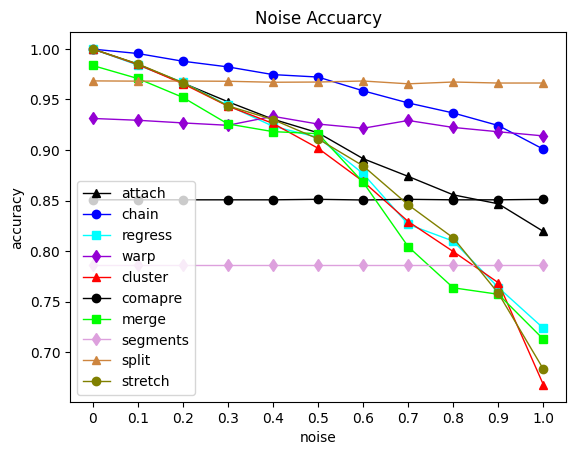

In [116]:
import matplotlib.pyplot as plt
plt.plot(mean_attach_results, color='Black', linewidth=1, marker='^')
plt.plot(mean_chain_results, color='Blue', linewidth=1, marker='o')
plt.plot(mean_regress_results, color='Aqua', linewidth=1, marker='s')
plt.plot(mean_warp_results, color='DarkViolet', linewidth=1, marker='d')

plt.plot(mean_cluster_results, color='Red', linewidth=1, marker='^')
plt.plot(mean_compare_results, color='Black', linewidth=1, marker='o')
plt.plot(mean_merge_results, color='lime', linewidth=1, marker='s')
plt.plot(mean_segments_results, color='plum', linewidth=1, marker='d')
plt.plot(mean_split_results, color='peru', linewidth=1, marker='^')
plt.plot(mean_stretch_results, color='olive', linewidth=1, marker='o')

plt.legend(['attach', 'chain', 'regress', 'warp', 'cluster','comapre','merge','segments','split','stretch'])
plt.ylabel('accuracy')
plt.xlabel('noise')

plt.title('Noise Accuarcy')
x_ticks_labels = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0']
plt.xticks(range(0, 11), x_ticks_labels)
#plt.savefig("noise_comparison.png")
plt.show()

In [117]:
print("mean attach:", statistics.mean(mean_attach_results))
print("mean chain:", statistics.mean(mean_chain_results))
print("mean regress:", statistics.mean(mean_regress_results))
print("mean warp:", statistics.mean(mean_warp_results))
print("mean cluster:", statistics.mean(mean_cluster_results))
print("mean compare:", statistics.mean(mean_compare_results))
print("mean merge:", statistics.mean(mean_merge_results))
print("mean segments:", statistics.mean(mean_segments_results))
print("mean split:", statistics.mean(mean_split_results))
print("mean stretch:", statistics.mean(mean_stretch_results))


mean attach: 0.9121358679877573
mean chain: 0.9617057770625183
mean regress: 0.8846590327983835
mean warp: 0.9250733271699249
mean cluster: 0.877772328054471
mean compare: 0.8508106424900558
mean merge: 0.8702231022249828
mean segments: 0.7862233022273994
mean split: 0.9673153686145751
mean stretch: 0.8837213452514073


Slope Error

In [118]:
attach_results = [[],[],[],[],[],[],[],[],[],[],[]]
chain_results = [[],[],[],[],[],[],[],[],[],[],[]]
regress_results = [[],[],[],[],[],[],[],[],[],[],[]]
warp_results = [[],[],[],[],[],[],[],[],[],[],[]]
cluster_results = [[],[],[],[],[],[],[],[],[],[],[]]
compare_results = [[],[],[],[],[],[],[],[],[],[],[]]
merge_results = [[],[],[],[],[],[],[],[],[],[],[]]
segment_results = [[],[],[],[],[],[],[],[],[],[],[]]
split_results = [[],[],[],[],[],[],[],[],[],[],[]]
stretch_results = [[],[],[],[],[],[],[],[],[],[],[]]

word_centers = correction.find_word_centers(aoi)
word_centers = np.array(word_centers.copy(), dtype=int)

duration_word_centers = correction.find_word_centers_and_duration(aois_with_tokens)
duration_word_centers = np.array(duration_word_centers.copy(), dtype=int)

# MAKE SURE YOU RUN THIS 100 TIMES, NOT JUST ONE!!!
for robot_index in tqdm(range(100)):#1 is for one robot
    print('robot ' + str(robot_index))
    
    for error_probability in range(0, 11):
        # generate error
        error_test = correction.error_slope(data['robot' + str(robot_index)].copy(),error_probability/10)

        # attach correction
        percentage, corrections, match_list = r.attach_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        attach_results[error_probability].append(percentage)

        # chain correction
        percentage, corrections, match_list = r.chain_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        chain_results[error_probability].append(percentage)
        
        # regress correction
        percentage, corrections, match_list = r.regress_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        regress_results[error_probability].append(percentage)
        
        # warp correction
        percentage, warp_correction, match_list = r.warp_correction(error_test, word_centers, aoi, data['robot' + str(robot_index)])
        warp_results[error_probability].append(percentage)

        # cluster correction
        percentage, corrections, match_list = r.cluster_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        cluster_results[error_probability].append(percentage)

        # compare correction
        percentage, corrections, match_list = r.compare_correction(error_test, line_ys, word_centers, aoi, data['robot' + str(robot_index)])
        compare_results[error_probability].append(percentage)

        # merge correction
        percentage, corrections, match_list = r.merge_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        merge_results[error_probability].append(percentage)

        # segment correction
        percentage, corrections, match_list = r.segment_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        segment_results[error_probability].append(percentage)

        # split correction
        percentage, corrections, match_list = r.split_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        split_results[error_probability].append(percentage)

        # stretch correction
        percentage, corrections, match_list = r.stretch_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        stretch_results[error_probability].append(percentage)


  0%|          | 0/100 [00:00<?, ?it/s]

robot 0


  1%|          | 1/100 [00:13<22:07, 13.41s/it]

robot 1


  2%|▏         | 2/100 [00:25<20:50, 12.76s/it]

robot 2


  3%|▎         | 3/100 [00:46<26:45, 16.55s/it]

robot 3


  4%|▍         | 4/100 [01:00<24:34, 15.36s/it]

robot 4


  5%|▌         | 5/100 [01:13<23:02, 14.55s/it]

robot 5


  6%|▌         | 6/100 [01:27<22:29, 14.35s/it]

robot 6


  7%|▋         | 7/100 [01:40<21:50, 14.09s/it]

robot 7


  8%|▊         | 8/100 [01:59<23:58, 15.64s/it]

robot 8


  9%|▉         | 9/100 [02:13<22:46, 15.02s/it]

robot 9


 10%|█         | 10/100 [02:32<24:09, 16.10s/it]

robot 10


 11%|█         | 11/100 [02:48<24:12, 16.32s/it]

robot 11


 12%|█▏        | 12/100 [03:01<22:26, 15.30s/it]

robot 12


 13%|█▎        | 13/100 [03:21<23:54, 16.49s/it]

robot 13


 14%|█▍        | 14/100 [03:32<21:31, 15.02s/it]

robot 14


 15%|█▌        | 15/100 [03:46<20:33, 14.51s/it]

robot 15


 16%|█▌        | 16/100 [03:58<19:26, 13.89s/it]

robot 16


 17%|█▋        | 17/100 [04:13<19:45, 14.29s/it]

robot 17


 18%|█▊        | 18/100 [04:26<19:03, 13.95s/it]

robot 18


 19%|█▉        | 19/100 [04:42<19:31, 14.46s/it]

robot 19


 20%|██        | 20/100 [04:57<19:21, 14.52s/it]

robot 20


 21%|██        | 21/100 [05:11<19:05, 14.50s/it]

robot 21


 22%|██▏       | 22/100 [05:27<19:25, 14.94s/it]

robot 22


 23%|██▎       | 23/100 [05:40<18:23, 14.33s/it]

robot 23


 24%|██▍       | 24/100 [05:55<18:18, 14.45s/it]

robot 24


 25%|██▌       | 25/100 [06:07<17:22, 13.90s/it]

robot 25


 26%|██▌       | 26/100 [06:21<16:58, 13.77s/it]

robot 26


 27%|██▋       | 27/100 [06:34<16:40, 13.70s/it]

robot 27


 28%|██▊       | 28/100 [06:46<15:40, 13.06s/it]

robot 28


 29%|██▉       | 29/100 [07:03<16:54, 14.28s/it]

robot 29


 30%|███       | 30/100 [07:15<15:43, 13.47s/it]

robot 30


 31%|███       | 31/100 [07:30<16:10, 14.06s/it]

robot 31


 32%|███▏      | 32/100 [07:52<18:36, 16.42s/it]

robot 32


 33%|███▎      | 33/100 [08:03<16:35, 14.85s/it]

robot 33


 34%|███▍      | 34/100 [08:18<16:22, 14.88s/it]

robot 34


 35%|███▌      | 35/100 [08:31<15:35, 14.39s/it]

robot 35


 36%|███▌      | 36/100 [08:47<15:35, 14.62s/it]

robot 36


 37%|███▋      | 37/100 [09:02<15:31, 14.79s/it]

robot 37


 38%|███▊      | 38/100 [09:16<15:16, 14.78s/it]

robot 38


 39%|███▉      | 39/100 [09:31<14:48, 14.56s/it]

robot 39


 40%|████      | 40/100 [09:43<13:50, 13.84s/it]

robot 40


 41%|████      | 41/100 [10:03<15:22, 15.63s/it]

robot 41


 42%|████▏     | 42/100 [10:19<15:18, 15.83s/it]

robot 42


 43%|████▎     | 43/100 [10:38<15:56, 16.77s/it]

robot 43


 44%|████▍     | 44/100 [10:52<14:55, 16.00s/it]

robot 44


 45%|████▌     | 45/100 [11:07<14:20, 15.64s/it]

robot 45


 46%|████▌     | 46/100 [11:19<13:15, 14.74s/it]

robot 46


 47%|████▋     | 47/100 [11:31<12:13, 13.84s/it]

robot 47


 48%|████▊     | 48/100 [11:41<11:02, 12.74s/it]

robot 48


 49%|████▉     | 49/100 [11:56<11:21, 13.36s/it]

robot 49


 50%|█████     | 50/100 [12:11<11:26, 13.74s/it]

robot 50


 51%|█████     | 51/100 [12:22<10:29, 12.85s/it]

robot 51


 52%|█████▏    | 52/100 [12:35<10:26, 13.06s/it]

robot 52


 53%|█████▎    | 53/100 [12:49<10:25, 13.32s/it]

robot 53


 54%|█████▍    | 54/100 [13:01<09:57, 12.98s/it]

robot 54


 55%|█████▌    | 55/100 [13:18<10:33, 14.07s/it]

robot 55


 56%|█████▌    | 56/100 [13:31<10:12, 13.92s/it]

robot 56


 57%|█████▋    | 57/100 [13:45<10:00, 13.96s/it]

robot 57


 58%|█████▊    | 58/100 [14:00<09:59, 14.29s/it]

robot 58


 59%|█████▉    | 59/100 [14:11<08:57, 13.11s/it]

robot 59


 60%|██████    | 60/100 [14:21<08:08, 12.22s/it]

robot 60


 61%|██████    | 61/100 [14:37<08:38, 13.29s/it]

robot 61


 62%|██████▏   | 62/100 [14:52<08:46, 13.84s/it]

robot 62


 63%|██████▎   | 63/100 [15:06<08:39, 14.04s/it]

robot 63


 64%|██████▍   | 64/100 [15:18<07:55, 13.21s/it]

robot 64


 65%|██████▌   | 65/100 [15:31<07:45, 13.30s/it]

robot 65


 66%|██████▌   | 66/100 [15:43<07:18, 12.88s/it]

robot 66


 67%|██████▋   | 67/100 [15:59<07:38, 13.88s/it]

robot 67


 68%|██████▊   | 68/100 [16:13<07:24, 13.90s/it]

robot 68


 69%|██████▉   | 69/100 [16:25<06:53, 13.34s/it]

robot 69


 70%|███████   | 70/100 [16:39<06:41, 13.37s/it]

robot 70


 71%|███████   | 71/100 [16:53<06:31, 13.49s/it]

robot 71


 72%|███████▏  | 72/100 [17:06<06:14, 13.38s/it]

robot 72


 73%|███████▎  | 73/100 [17:16<05:37, 12.51s/it]

robot 73


 74%|███████▍  | 74/100 [17:27<05:16, 12.16s/it]

robot 74


 75%|███████▌  | 75/100 [17:43<05:32, 13.31s/it]

robot 75


 76%|███████▌  | 76/100 [17:54<05:01, 12.57s/it]

robot 76


 77%|███████▋  | 77/100 [18:07<04:49, 12.60s/it]

robot 77


 78%|███████▊  | 78/100 [18:22<04:52, 13.29s/it]

robot 78


 79%|███████▉  | 79/100 [18:36<04:44, 13.54s/it]

robot 79


 80%|████████  | 80/100 [18:56<05:07, 15.36s/it]

robot 80


 81%|████████  | 81/100 [19:15<05:12, 16.45s/it]

robot 81


 82%|████████▏ | 82/100 [19:29<04:44, 15.79s/it]

robot 82


 83%|████████▎ | 83/100 [19:41<04:11, 14.77s/it]

robot 83


 84%|████████▍ | 84/100 [19:54<03:47, 14.19s/it]

robot 84


 85%|████████▌ | 85/100 [20:04<03:13, 12.91s/it]

robot 85


 86%|████████▌ | 86/100 [20:16<02:57, 12.71s/it]

robot 86


 87%|████████▋ | 87/100 [20:34<03:03, 14.11s/it]

robot 87


 88%|████████▊ | 88/100 [20:47<02:44, 13.74s/it]

robot 88


 89%|████████▉ | 89/100 [20:58<02:23, 13.06s/it]

robot 89


 90%|█████████ | 90/100 [21:10<02:06, 12.64s/it]

robot 90


 91%|█████████ | 91/100 [21:22<01:52, 12.50s/it]

robot 91


 92%|█████████▏| 92/100 [21:38<01:48, 13.57s/it]

robot 92


 93%|█████████▎| 93/100 [21:51<01:33, 13.37s/it]

robot 93


 94%|█████████▍| 94/100 [22:05<01:21, 13.52s/it]

robot 94


 95%|█████████▌| 95/100 [22:19<01:08, 13.66s/it]

robot 95


 96%|█████████▌| 96/100 [22:35<00:57, 14.40s/it]

robot 96


 97%|█████████▋| 97/100 [22:51<00:44, 14.88s/it]

robot 97


 98%|█████████▊| 98/100 [23:02<00:27, 13.93s/it]

robot 98


 99%|█████████▉| 99/100 [23:20<00:15, 15.08s/it]

robot 99


100%|██████████| 100/100 [23:32<00:00, 14.13s/it]


In [119]:
mean_attach_results = mean_error_group(attach_results)
mean_chain_results = mean_error_group(chain_results)
mean_regress_results = mean_error_group(regress_results)
mean_warp_results = mean_error_group(warp_results)
mean_cluster_results = mean_error_group(cluster_results)
mean_compare_results = mean_error_group(compare_results)
mean_merge_results = mean_error_group(merge_results)
mean_segments_results = mean_error_group(segment_results)
mean_split_results = mean_error_group(split_results)
mean_stretch_results = mean_error_group(stretch_results)

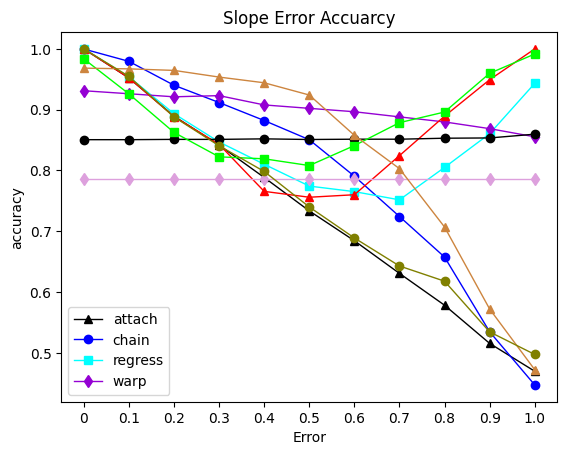

In [120]:
plt.plot(mean_attach_results, color='Black', linewidth=1, marker='^')
plt.plot(mean_chain_results, color='Blue', linewidth=1, marker='o')
plt.plot(mean_regress_results, color='Aqua', linewidth=1, marker='s')
plt.plot(mean_warp_results, color='DarkViolet', linewidth=1, marker='d')

plt.plot(mean_cluster_results, color='Red', linewidth=1, marker='^')
plt.plot(mean_compare_results, color='Black', linewidth=1, marker='o')
plt.plot(mean_merge_results, color='lime', linewidth=1, marker='s')
plt.plot(mean_segments_results, color='plum', linewidth=1, marker='d')
plt.plot(mean_split_results, color='peru', linewidth=1, marker='^')
plt.plot(mean_stretch_results, color='olive', linewidth=1, marker='o')

plt.legend(['attach', 'chain', 'regress', 'warp'])
plt.ylabel('accuracy')
plt.xlabel('Error')

plt.title('Slope Error Accuarcy')
x_ticks_labels = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0']
plt.xticks(range(0, 11), x_ticks_labels)
#plt.savefig("noise_comparison.png")
plt.show()

In [121]:
print("mean attach:", statistics.mean(mean_attach_results))
print("mean chain:", statistics.mean(mean_chain_results))
print("mean regress:", statistics.mean(mean_regress_results))
print("mean warp:", statistics.mean(mean_warp_results))
print("mean cluster:", statistics.mean(mean_cluster_results))
print("mean compare:", statistics.mean(mean_compare_results))
print("mean merge:", statistics.mean(mean_merge_results))
print("mean segments:", statistics.mean(mean_segments_results))
print("mean split:", statistics.mean(mean_split_results))
print("mean stretch:", statistics.mean(mean_stretch_results))

mean attach: 0.7349256841462126
mean chain: 0.7925908088172875
mean regress: 0.8549839469651909
mean warp: 0.9000853720157838
mean cluster: 0.8753416808421316
mean compare: 0.8523681595140771
mean merge: 0.8899420584036364
mean segments: 0.7862233022273994
mean split: 0.8304198698225427
mean stretch: 0.7457675809970782


Shift Error

In [122]:
attach_results = [[],[],[],[],[],[],[],[],[],[],[]]
chain_results = [[],[],[],[],[],[],[],[],[],[],[]]
regress_results = [[],[],[],[],[],[],[],[],[],[],[]]
warp_results = [[],[],[],[],[],[],[],[],[],[],[]]
cluster_results = [[],[],[],[],[],[],[],[],[],[],[]]
compare_results = [[],[],[],[],[],[],[],[],[],[],[]]
merge_results = [[],[],[],[],[],[],[],[],[],[],[]]
segment_results = [[],[],[],[],[],[],[],[],[],[],[]]
split_results = [[],[],[],[],[],[],[],[],[],[],[]]
stretch_results = [[],[],[],[],[],[],[],[],[],[],[]]

word_centers = correction.find_word_centers(aoi)
word_centers = np.array(word_centers.copy(), dtype=int)

duration_word_centers = correction.find_word_centers_and_duration(aois_with_tokens)
duration_word_centers = np.array(duration_word_centers.copy(), dtype=int)

# MAKE SURE YOU RUN THIS 100 TIMES, NOT JUST ONE!!!
for robot_index in tqdm(range(100)):#1 is for one robot
    print('robot ' + str(robot_index))
    
    for error_probability in range(0, 11):
        # generate error
        error_test = correction.error_shift(data['robot' + str(robot_index)].copy(),error_probability/10)

        # attach correction
        percentage, corrections, match_list = r.attach_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        attach_results[error_probability].append(percentage)

        # chain correction
        percentage, corrections, match_list = r.chain_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        chain_results[error_probability].append(percentage)
        
        # regress correction
        percentage, corrections, match_list = r.regress_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        regress_results[error_probability].append(percentage)
        
        # warp correction
        percentage, warp_correction, match_list = r.warp_correction(error_test, word_centers, aoi, data['robot' + str(robot_index)])
        warp_results[error_probability].append(percentage)

        # cluster correction
        percentage, corrections, match_list = r.cluster_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        cluster_results[error_probability].append(percentage)

        # compare correction
        percentage, corrections, match_list = r.compare_correction(error_test, line_ys, word_centers, aoi, data['robot' + str(robot_index)])
        compare_results[error_probability].append(percentage)

        # merge correction
        percentage, corrections, match_list = r.merge_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        merge_results[error_probability].append(percentage)

        # segment correction
        percentage, corrections, match_list = r.segment_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        segment_results[error_probability].append(percentage)

        # split correction
        percentage, corrections, match_list = r.split_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        split_results[error_probability].append(percentage)

        # stretch correction
        percentage, corrections, match_list = r.stretch_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        stretch_results[error_probability].append(percentage)


  0%|          | 0/100 [00:00<?, ?it/s]

robot 0


  1%|          | 1/100 [00:13<22:52, 13.86s/it]

robot 1


  2%|▏         | 2/100 [00:26<21:32, 13.19s/it]

robot 2


  3%|▎         | 3/100 [00:48<27:30, 17.02s/it]

robot 3


  4%|▍         | 4/100 [01:02<25:23, 15.87s/it]

robot 4


  5%|▌         | 5/100 [01:15<23:48, 15.03s/it]

robot 5


  6%|▌         | 6/100 [01:30<23:24, 14.94s/it]

robot 6


  7%|▋         | 7/100 [01:45<23:02, 14.87s/it]

robot 7


  8%|▊         | 8/100 [02:05<25:12, 16.44s/it]

robot 8


  9%|▉         | 9/100 [02:19<24:07, 15.91s/it]

robot 9


 10%|█         | 10/100 [02:39<25:28, 16.98s/it]

robot 10


 11%|█         | 11/100 [02:57<25:39, 17.30s/it]

robot 11


/Users/jonnasosauranga/Desktop/CS421-project1/my_refactor.py:140: RankWarning: Polyfit may be poorly conditioned
  corrections = algo.merge(np_array, line_ys)
/Users/jonnasosauranga/Desktop/CS421-project1/my_refactor.py:140: RankWarning: Polyfit may be poorly conditioned
  corrections = algo.merge(np_array, line_ys)
/Users/jonnasosauranga/Desktop/CS421-project1/my_refactor.py:140: RankWarning: Polyfit may be poorly conditioned
  corrections = algo.merge(np_array, line_ys)
/Users/jonnasosauranga/Desktop/CS421-project1/my_refactor.py:140: RankWarning: Polyfit may be poorly conditioned
  corrections = algo.merge(np_array, line_ys)
/Users/jonnasosauranga/Desktop/CS421-project1/my_refactor.py:140: RankWarning: Polyfit may be poorly conditioned
  corrections = algo.merge(np_array, line_ys)
 12%|█▏        | 12/100 [03:11<23:54, 16.30s/it]

robot 12


 13%|█▎        | 13/100 [03:31<25:24, 17.52s/it]

robot 13


 14%|█▍        | 14/100 [03:43<22:48, 15.92s/it]

robot 14


 15%|█▌        | 15/100 [03:57<21:42, 15.32s/it]

robot 15


 16%|█▌        | 16/100 [04:10<20:15, 14.47s/it]

robot 16


 17%|█▋        | 17/100 [04:26<20:44, 14.99s/it]

robot 17


 18%|█▊        | 18/100 [04:39<19:53, 14.55s/it]

robot 18


 19%|█▉        | 19/100 [04:56<20:21, 15.08s/it]

robot 19


 20%|██        | 20/100 [05:10<19:56, 14.95s/it]

robot 20


 21%|██        | 21/100 [05:24<19:19, 14.68s/it]

robot 21


 22%|██▏       | 22/100 [05:41<19:39, 15.12s/it]

robot 22


/Users/jonnasosauranga/Desktop/CS421-project1/my_refactor.py:140: RankWarning: Polyfit may be poorly conditioned
  corrections = algo.merge(np_array, line_ys)
 23%|██▎       | 23/100 [05:54<18:41, 14.57s/it]

robot 23


 24%|██▍       | 24/100 [06:09<18:44, 14.80s/it]

robot 24


 25%|██▌       | 25/100 [06:23<18:05, 14.47s/it]

robot 25


 26%|██▌       | 26/100 [06:37<17:51, 14.47s/it]

robot 26


 27%|██▋       | 27/100 [06:52<17:34, 14.44s/it]

robot 27


 28%|██▊       | 28/100 [07:06<17:08, 14.28s/it]

robot 28


 29%|██▉       | 29/100 [07:23<18:06, 15.31s/it]

robot 29


 30%|███       | 30/100 [07:36<16:52, 14.46s/it]

robot 30


 31%|███       | 31/100 [07:52<17:05, 14.86s/it]

robot 31


 32%|███▏      | 32/100 [08:15<19:46, 17.45s/it]

robot 32


 33%|███▎      | 33/100 [08:27<17:31, 15.70s/it]

robot 33


 34%|███▍      | 34/100 [08:43<17:21, 15.78s/it]

robot 34


 35%|███▌      | 35/100 [08:57<16:31, 15.26s/it]

robot 35


 36%|███▌      | 36/100 [09:13<16:29, 15.46s/it]

robot 36


 37%|███▋      | 37/100 [09:28<16:12, 15.43s/it]

robot 37


 38%|███▊      | 38/100 [09:44<16:07, 15.61s/it]

robot 38


/Users/jonnasosauranga/Desktop/CS421-project1/my_refactor.py:140: RankWarning: Polyfit may be poorly conditioned
  corrections = algo.merge(np_array, line_ys)
/Users/jonnasosauranga/Desktop/CS421-project1/my_refactor.py:140: RankWarning: Polyfit may be poorly conditioned
  corrections = algo.merge(np_array, line_ys)
/Users/jonnasosauranga/Desktop/CS421-project1/my_refactor.py:140: RankWarning: Polyfit may be poorly conditioned
  corrections = algo.merge(np_array, line_ys)
 39%|███▉      | 39/100 [09:59<15:33, 15.30s/it]

robot 39


 40%|████      | 40/100 [10:12<14:33, 14.57s/it]

robot 40


 41%|████      | 41/100 [10:32<16:07, 16.39s/it]

robot 41


 42%|████▏     | 42/100 [10:49<16:01, 16.57s/it]

robot 42


 43%|████▎     | 43/100 [11:09<16:43, 17.60s/it]

robot 43


 44%|████▍     | 44/100 [11:24<15:44, 16.87s/it]

robot 44


 45%|████▌     | 45/100 [11:40<15:13, 16.61s/it]

robot 45


 46%|████▌     | 46/100 [11:54<14:01, 15.59s/it]

robot 46


 47%|████▋     | 47/100 [12:06<12:55, 14.63s/it]

robot 47


 48%|████▊     | 48/100 [12:16<11:31, 13.31s/it]

robot 48


 49%|████▉     | 49/100 [12:32<11:50, 13.93s/it]

robot 49


 50%|█████     | 50/100 [12:47<11:56, 14.34s/it]

robot 50


 51%|█████     | 51/100 [13:00<11:25, 13.99s/it]

robot 51


 52%|█████▏    | 52/100 [13:15<11:26, 14.30s/it]

robot 52


 53%|█████▎    | 53/100 [13:30<11:27, 14.63s/it]

robot 53


 54%|█████▍    | 54/100 [13:45<11:06, 14.49s/it]

robot 54


 55%|█████▌    | 55/100 [14:02<11:35, 15.45s/it]

robot 55


 56%|█████▌    | 56/100 [14:16<11:02, 15.05s/it]

robot 56


 57%|█████▋    | 57/100 [14:32<10:49, 15.10s/it]

robot 57


 58%|█████▊    | 58/100 [14:52<11:34, 16.54s/it]

robot 58


 59%|█████▉    | 59/100 [15:02<10:05, 14.77s/it]

robot 59


 60%|██████    | 60/100 [15:13<09:04, 13.61s/it]

robot 60


 61%|██████    | 61/100 [15:30<09:27, 14.54s/it]

robot 61


 62%|██████▏   | 62/100 [15:45<09:25, 14.88s/it]

robot 62


 63%|██████▎   | 63/100 [16:01<09:14, 14.98s/it]

robot 63


 64%|██████▍   | 64/100 [16:12<08:22, 13.96s/it]

robot 64


 65%|██████▌   | 65/100 [16:26<08:10, 14.03s/it]

robot 65


 66%|██████▌   | 66/100 [16:39<07:41, 13.57s/it]

robot 66


 67%|██████▋   | 67/100 [16:56<08:00, 14.55s/it]

robot 67


 68%|██████▊   | 68/100 [17:11<07:49, 14.67s/it]

robot 68


 69%|██████▉   | 69/100 [17:23<07:16, 14.08s/it]

robot 69


 70%|███████   | 70/100 [17:37<07:00, 14.03s/it]

robot 70


 71%|███████   | 71/100 [17:52<06:51, 14.18s/it]

robot 71


 72%|███████▏  | 72/100 [18:06<06:33, 14.06s/it]

robot 72


 73%|███████▎  | 73/100 [18:17<05:55, 13.15s/it]

robot 73


 74%|███████▍  | 74/100 [18:29<05:35, 12.91s/it]

robot 74


 75%|███████▌  | 75/100 [18:46<05:53, 14.16s/it]

robot 75


 76%|███████▌  | 76/100 [18:58<05:20, 13.34s/it]

robot 76


 77%|███████▋  | 77/100 [19:11<05:07, 13.36s/it]

robot 77


 78%|███████▊  | 78/100 [19:27<05:08, 14.04s/it]

robot 78


 79%|███████▉  | 79/100 [19:41<04:59, 14.28s/it]

robot 79


 80%|████████  | 80/100 [20:02<05:23, 16.18s/it]

robot 80


 81%|████████  | 81/100 [20:22<05:30, 17.40s/it]

robot 81


 82%|████████▏ | 82/100 [20:37<05:00, 16.69s/it]

robot 82


 83%|████████▎ | 83/100 [20:51<04:27, 15.71s/it]

robot 83


 84%|████████▍ | 84/100 [21:04<04:01, 15.08s/it]

robot 84


 85%|████████▌ | 85/100 [21:15<03:25, 13.71s/it]

robot 85


 86%|████████▌ | 86/100 [21:27<03:07, 13.38s/it]

robot 86


 87%|████████▋ | 87/100 [21:46<03:13, 14.86s/it]

robot 87


 88%|████████▊ | 88/100 [22:00<02:54, 14.53s/it]

robot 88


 89%|████████▉ | 89/100 [22:11<02:30, 13.72s/it]

robot 89


 90%|█████████ | 90/100 [22:23<02:12, 13.22s/it]

robot 90


 91%|█████████ | 91/100 [22:36<01:57, 13.10s/it]

robot 91


 92%|█████████▏| 92/100 [22:52<01:52, 14.03s/it]

robot 92


 93%|█████████▎| 93/100 [23:06<01:37, 13.99s/it]

robot 93


 94%|█████████▍| 94/100 [23:21<01:24, 14.12s/it]

robot 94


 95%|█████████▌| 95/100 [23:36<01:11, 14.33s/it]

robot 95


 96%|█████████▌| 96/100 [23:53<01:00, 15.16s/it]

robot 96


 97%|█████████▋| 97/100 [24:09<00:46, 15.57s/it]

robot 97


 98%|█████████▊| 98/100 [24:22<00:29, 14.65s/it]

robot 98


 99%|█████████▉| 99/100 [24:40<00:15, 15.74s/it]

robot 99


100%|██████████| 100/100 [24:53<00:00, 14.93s/it]


In [123]:
mean_attach_results = mean_error_group(attach_results)
mean_chain_results = mean_error_group(chain_results)
mean_regress_results = mean_error_group(regress_results)
mean_warp_results = mean_error_group(warp_results)
mean_cluster_results = mean_error_group(cluster_results)
mean_compare_results = mean_error_group(compare_results)
mean_merge_results = mean_error_group(merge_results)
mean_segments_results = mean_error_group(segment_results)
mean_split_results = mean_error_group(split_results)
mean_stretch_results = mean_error_group(stretch_results)

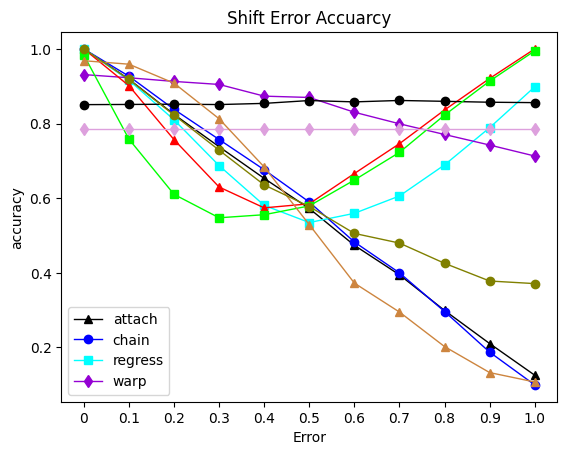

In [124]:
plt.plot(mean_attach_results, color='Black', linewidth=1, marker='^')
plt.plot(mean_chain_results, color='Blue', linewidth=1, marker='o')
plt.plot(mean_regress_results, color='Aqua', linewidth=1, marker='s')
plt.plot(mean_warp_results, color='DarkViolet', linewidth=1, marker='d')

plt.plot(mean_cluster_results, color='Red', linewidth=1, marker='^')
plt.plot(mean_compare_results, color='Black', linewidth=1, marker='o')
plt.plot(mean_merge_results, color='lime', linewidth=1, marker='s')
plt.plot(mean_segments_results, color='plum', linewidth=1, marker='d')
plt.plot(mean_split_results, color='peru', linewidth=1, marker='^')
plt.plot(mean_stretch_results, color='olive', linewidth=1, marker='o')

plt.legend(['attach', 'chain', 'regress', 'warp'])
plt.ylabel('accuracy')
plt.xlabel('Error')

plt.title('Shift Error Accuarcy')
x_ticks_labels = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0']
plt.xticks(range(0, 11), x_ticks_labels)
#plt.savefig("noise_comparison.png")
plt.show()

In [125]:
print("mean attach:", statistics.mean(mean_attach_results))
print("mean chain:", statistics.mean(mean_chain_results))
print("mean regress:", statistics.mean(mean_regress_results))
print("mean warp:", statistics.mean(mean_warp_results))
print("mean cluster:", statistics.mean(mean_cluster_results))
print("mean compare:", statistics.mean(mean_compare_results))
print("mean merge:", statistics.mean(mean_merge_results))
print("mean segments:", statistics.mean(mean_segments_results))
print("mean split:", statistics.mean(mean_split_results))
print("mean stretch:", statistics.mean(mean_stretch_results))

mean attach: 0.5645421103867189
mean chain: 0.5685133821924396
mean regress: 0.733703258831692
mean warp: 0.8427870573337786
mean cluster: 0.7833182022765544
mean compare: 0.8557337084598561
mean merge: 0.7397609687763727
mean segments: 0.7862233022273994
mean split: 0.5427825933115273
mean stretch: 0.622047571995422


Within the line

In [132]:
attach_results = [[],[],[],[],[],[],[],[],[],[],[]]
chain_results = [[],[],[],[],[],[],[],[],[],[],[]]
regress_results = [[],[],[],[],[],[],[],[],[],[],[]]
warp_results = [[],[],[],[],[],[],[],[],[],[],[]]
cluster_results = [[],[],[],[],[],[],[],[],[],[],[]]
compare_results = [[],[],[],[],[],[],[],[],[],[],[]]
merge_results = [[],[],[],[],[],[],[],[],[],[],[]]
segment_results = [[],[],[],[],[],[],[],[],[],[],[]]
split_results = [[],[],[],[],[],[],[],[],[],[],[]]
stretch_results = [[],[],[],[],[],[],[],[],[],[],[]]

word_centers = correction.find_word_centers(aoi)
word_centers = np.array(word_centers.copy(), dtype=int)

duration_word_centers = correction.find_word_centers_and_duration(aois_with_tokens)
duration_word_centers = np.array(duration_word_centers.copy(), dtype=int)

# MAKE SURE YOU RUN THIS 100 TIMES, NOT JUST ONE!!!
for robot_index in tqdm(range(100)):#1 is for one robot
    print('robot ' + str(robot_index))
    
    for error_probability in range(0, 11):
        # generate error
        error_test = correction.error_within_line(data['robot' + str(robot_index)].copy(),error_probability/10,line_ys)

        # attach correction
        percentage, corrections, match_list = r.attach_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        attach_results[error_probability].append(percentage)

        # chain correction
        percentage, corrections, match_list = r.chain_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        chain_results[error_probability].append(percentage)
        
        # regress correction
        percentage, corrections, match_list = r.regress_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        regress_results[error_probability].append(percentage)
        
        # warp correction
        percentage, warp_correction, match_list = r.warp_correction(error_test, word_centers, aoi, data['robot' + str(robot_index)])
        warp_results[error_probability].append(percentage)

        # cluster correction
        percentage, corrections, match_list = r.cluster_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        cluster_results[error_probability].append(percentage)

        # compare correction
        percentage, corrections, match_list = r.compare_correction(error_test, line_ys, word_centers, aoi, data['robot' + str(robot_index)])
        compare_results[error_probability].append(percentage)

        # merge correction
        percentage, corrections, match_list = r.merge_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        merge_results[error_probability].append(percentage)

        # segment correction
        percentage, corrections, match_list = r.segment_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        segment_results[error_probability].append(percentage)

        # split correction
        percentage, corrections, match_list = r.split_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        split_results[error_probability].append(percentage)

        # stretch correction
        percentage, corrections, match_list = r.stretch_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        stretch_results[error_probability].append(percentage)

  0%|          | 0/100 [00:00<?, ?it/s]

robot 0


  1%|          | 1/100 [00:14<24:01, 14.56s/it]

robot 1


  2%|▏         | 2/100 [00:27<22:25, 13.73s/it]

robot 2


  3%|▎         | 3/100 [00:51<29:39, 18.34s/it]

robot 3


  4%|▍         | 4/100 [01:05<26:49, 16.77s/it]

robot 4


  5%|▌         | 5/100 [01:19<24:39, 15.58s/it]

robot 5


  6%|▌         | 6/100 [01:34<24:16, 15.50s/it]

robot 6


  7%|▋         | 7/100 [01:49<23:34, 15.21s/it]

robot 7


  8%|▊         | 8/100 [02:09<25:41, 16.75s/it]

robot 8


  9%|▉         | 9/100 [02:24<24:29, 16.15s/it]

robot 9


 10%|█         | 10/100 [02:44<26:04, 17.39s/it]

robot 10


 11%|█         | 11/100 [03:02<26:16, 17.71s/it]

robot 11


 12%|█▏        | 12/100 [03:16<24:24, 16.64s/it]

robot 12


 13%|█▎        | 13/100 [03:39<26:32, 18.31s/it]

robot 13


 14%|█▍        | 14/100 [03:51<23:46, 16.59s/it]

robot 14


 15%|█▌        | 15/100 [04:06<22:33, 15.92s/it]

robot 15


 16%|█▌        | 16/100 [04:18<20:51, 14.89s/it]

robot 16


 17%|█▋        | 17/100 [04:34<21:10, 15.30s/it]

robot 17


 18%|█▊        | 18/100 [04:48<20:13, 14.80s/it]

robot 18


 19%|█▉        | 19/100 [05:05<20:51, 15.46s/it]

robot 19


 20%|██        | 20/100 [05:20<20:30, 15.38s/it]

robot 20


 21%|██        | 21/100 [05:35<19:58, 15.17s/it]

robot 21


 22%|██▏       | 22/100 [05:52<20:30, 15.77s/it]

robot 22


 23%|██▎       | 23/100 [06:05<19:17, 15.03s/it]

robot 23


 24%|██▍       | 24/100 [06:22<19:30, 15.40s/it]

robot 24


 25%|██▌       | 25/100 [06:36<18:51, 15.09s/it]

robot 25


 26%|██▌       | 26/100 [06:51<18:36, 15.09s/it]

robot 26


 27%|██▋       | 27/100 [07:06<18:16, 15.02s/it]

robot 27


 28%|██▊       | 28/100 [07:18<16:57, 14.13s/it]

robot 28


 29%|██▉       | 29/100 [07:37<18:27, 15.60s/it]

robot 29


 30%|███       | 30/100 [07:49<17:01, 14.59s/it]

robot 30


 31%|███       | 31/100 [08:06<17:32, 15.25s/it]

robot 31


 32%|███▏      | 32/100 [08:31<20:43, 18.29s/it]

robot 32


 33%|███▎      | 33/100 [08:44<18:24, 16.48s/it]

robot 33


 34%|███▍      | 34/100 [09:00<18:10, 16.52s/it]

robot 34


 35%|███▌      | 35/100 [09:14<16:58, 15.67s/it]

robot 35


 36%|███▌      | 36/100 [09:30<16:54, 15.86s/it]

robot 36


 37%|███▋      | 37/100 [09:47<16:54, 16.10s/it]

robot 37


 38%|███▊      | 38/100 [10:03<16:46, 16.23s/it]

robot 38


 39%|███▉      | 39/100 [10:18<16:01, 15.75s/it]

robot 39


 40%|████      | 40/100 [10:31<14:49, 14.83s/it]

robot 40


 41%|████      | 41/100 [10:52<16:33, 16.84s/it]

robot 41


 42%|████▏     | 42/100 [11:11<16:40, 17.24s/it]

robot 42


 43%|████▎     | 43/100 [11:32<17:38, 18.57s/it]

robot 43


 44%|████▍     | 44/100 [11:49<16:43, 17.93s/it]

robot 44


 45%|████▌     | 45/100 [12:05<16:01, 17.49s/it]

robot 45


 46%|████▌     | 46/100 [12:18<14:37, 16.25s/it]

robot 46


 47%|████▋     | 47/100 [12:31<13:21, 15.12s/it]

robot 47


 48%|████▊     | 48/100 [12:41<11:54, 13.74s/it]

robot 48


 49%|████▉     | 49/100 [12:57<12:13, 14.39s/it]

robot 49


 50%|█████     | 50/100 [13:13<12:21, 14.82s/it]

robot 50


 51%|█████     | 51/100 [13:25<11:14, 13.78s/it]

robot 51


 52%|█████▏    | 52/100 [13:39<11:08, 13.94s/it]

robot 52


 53%|█████▎    | 53/100 [13:54<11:17, 14.41s/it]

robot 53


 54%|█████▍    | 54/100 [14:08<10:50, 14.13s/it]

robot 54


 55%|█████▌    | 55/100 [14:26<11:34, 15.44s/it]

robot 55


 56%|█████▌    | 56/100 [14:41<11:05, 15.12s/it]

robot 56


 57%|█████▋    | 57/100 [14:56<10:50, 15.13s/it]

robot 57


 58%|█████▊    | 58/100 [15:12<10:48, 15.45s/it]

robot 58


 59%|█████▉    | 59/100 [15:23<09:38, 14.12s/it]

robot 59


 60%|██████    | 60/100 [15:34<08:42, 13.07s/it]

robot 60


 61%|██████    | 61/100 [15:51<09:16, 14.27s/it]

robot 61


 62%|██████▏   | 62/100 [16:07<09:25, 14.87s/it]

robot 62


 63%|██████▎   | 63/100 [16:23<09:21, 15.17s/it]

robot 63


 64%|██████▍   | 64/100 [16:35<08:30, 14.18s/it]

robot 64


 65%|██████▌   | 65/100 [16:49<08:20, 14.30s/it]

robot 65


 66%|██████▌   | 66/100 [17:02<07:53, 13.94s/it]

robot 66


 67%|██████▋   | 67/100 [17:20<08:11, 14.90s/it]

robot 67


 68%|██████▊   | 68/100 [17:35<08:01, 15.04s/it]

robot 68


 69%|██████▉   | 69/100 [17:48<07:24, 14.33s/it]

robot 69


 70%|███████   | 70/100 [18:02<07:11, 14.38s/it]

robot 70


 71%|███████   | 71/100 [18:17<07:01, 14.52s/it]

robot 71


 72%|███████▏  | 72/100 [18:31<06:43, 14.41s/it]

robot 72


 73%|███████▎  | 73/100 [18:42<06:01, 13.38s/it]

robot 73


 74%|███████▍  | 74/100 [18:54<05:37, 12.96s/it]

robot 74


 75%|███████▌  | 75/100 [19:12<06:00, 14.42s/it]

robot 75


 76%|███████▌  | 76/100 [19:24<05:26, 13.61s/it]

robot 76


 77%|███████▋  | 77/100 [19:37<05:14, 13.67s/it]

robot 77


 78%|███████▊  | 78/100 [19:53<05:15, 14.36s/it]

robot 78


 79%|███████▉  | 79/100 [20:09<05:07, 14.66s/it]

robot 79


 80%|████████  | 80/100 [20:31<05:38, 16.95s/it]

robot 80


 81%|████████  | 81/100 [20:53<05:49, 18.39s/it]

robot 81


 82%|████████▏ | 82/100 [21:08<05:16, 17.56s/it]

robot 82


 83%|████████▎ | 83/100 [21:22<04:37, 16.34s/it]

robot 83


 84%|████████▍ | 84/100 [21:36<04:11, 15.72s/it]

robot 84


 85%|████████▌ | 85/100 [21:47<03:32, 14.16s/it]

robot 85


 86%|████████▌ | 86/100 [22:00<03:14, 13.89s/it]

robot 86


 87%|████████▋ | 87/100 [22:20<03:22, 15.61s/it]

robot 87


 88%|████████▊ | 88/100 [22:34<03:01, 15.15s/it]

robot 88


 89%|████████▉ | 89/100 [22:45<02:35, 14.14s/it]

robot 89


 90%|█████████ | 90/100 [22:58<02:17, 13.76s/it]

robot 90


 91%|█████████ | 91/100 [23:11<02:00, 13.44s/it]

robot 91


 92%|█████████▏| 92/100 [23:28<01:55, 14.40s/it]

robot 92


 93%|█████████▎| 93/100 [23:41<01:39, 14.21s/it]

robot 93


 94%|█████████▍| 94/100 [23:56<01:25, 14.30s/it]

robot 94


 95%|█████████▌| 95/100 [24:11<01:12, 14.53s/it]

robot 95


 96%|█████████▌| 96/100 [24:29<01:01, 15.47s/it]

robot 96


 97%|█████████▋| 97/100 [24:46<00:47, 15.92s/it]

robot 97


 98%|█████████▊| 98/100 [24:58<00:29, 14.90s/it]

robot 98


 99%|█████████▉| 99/100 [25:18<00:16, 16.25s/it]

robot 99


100%|██████████| 100/100 [25:30<00:00, 15.31s/it]


In [133]:
mean_attach_results = mean_error_group(attach_results)
mean_chain_results = mean_error_group(chain_results)
mean_regress_results = mean_error_group(regress_results)
mean_warp_results = mean_error_group(warp_results)
mean_cluster_results = mean_error_group(cluster_results)
mean_compare_results = mean_error_group(compare_results)
mean_merge_results = mean_error_group(merge_results)
mean_segments_results = mean_error_group(segment_results)
mean_split_results = mean_error_group(split_results)
mean_stretch_results = mean_error_group(stretch_results)

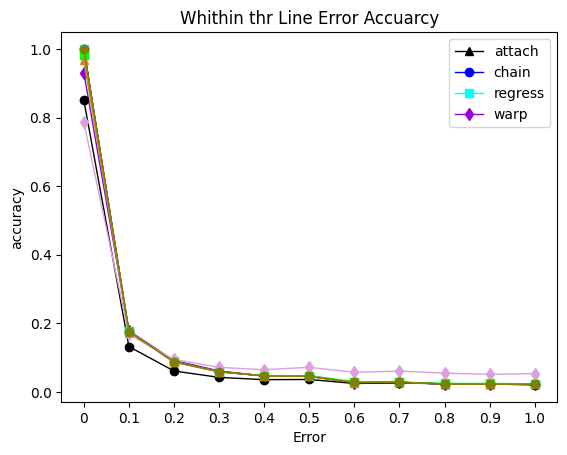

In [134]:
plt.plot(mean_attach_results, color='Black', linewidth=1, marker='^')
plt.plot(mean_chain_results, color='Blue', linewidth=1, marker='o')
plt.plot(mean_regress_results, color='Aqua', linewidth=1, marker='s')
plt.plot(mean_warp_results, color='DarkViolet', linewidth=1, marker='d')

plt.plot(mean_cluster_results, color='Red', linewidth=1, marker='^')
plt.plot(mean_compare_results, color='Black', linewidth=1, marker='o')
plt.plot(mean_merge_results, color='lime', linewidth=1, marker='s')
plt.plot(mean_segments_results, color='plum', linewidth=1, marker='d')
plt.plot(mean_split_results, color='peru', linewidth=1, marker='^')
plt.plot(mean_stretch_results, color='olive', linewidth=1, marker='o')

plt.legend(['attach', 'chain', 'regress', 'warp'])
plt.ylabel('accuracy')
plt.xlabel('Error')

plt.title('Whithin thr Line Error Accuarcy')
x_ticks_labels = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0']
plt.xticks(range(0, 11), x_ticks_labels)
#plt.savefig("noise_comparison.png")
plt.show()

In [135]:
print("mean attach:", statistics.mean(mean_attach_results))
print("mean chain:", statistics.mean(mean_chain_results))
print("mean regress:", statistics.mean(mean_regress_results))
print("mean warp:", statistics.mean(mean_warp_results))
print("mean cluster:", statistics.mean(mean_cluster_results))
print("mean compare:", statistics.mean(mean_compare_results))
print("mean merge:", statistics.mean(mean_merge_results))
print("mean segments:", statistics.mean(mean_segments_results))
print("mean split:", statistics.mean(mean_split_results))
print("mean stretch:", statistics.mean(mean_stretch_results))

mean attach: 0.1399739574068201
mean chain: 0.13995828342562885
mean regress: 0.1399739574068201
mean warp: 0.13455252466672799
mean cluster: 0.1399739574068201
mean compare: 0.11609013557807686
mean merge: 0.13941388621337808
mean segments: 0.13950046287568918
mean split: 0.13672457235825475
mean stretch: 0.1399739574068201


Between the line error

In [171]:
attach_results = [[],[],[],[],[],[],[],[],[],[],[]]
chain_results = [[],[],[],[],[],[],[],[],[],[],[]]
regress_results = [[],[],[],[],[],[],[],[],[],[],[]]
warp_results = [[],[],[],[],[],[],[],[],[],[],[]]
cluster_results = [[],[],[],[],[],[],[],[],[],[],[]]
compare_results = [[],[],[],[],[],[],[],[],[],[],[]]
merge_results = [[],[],[],[],[],[],[],[],[],[],[]]
segment_results = [[],[],[],[],[],[],[],[],[],[],[]]
split_results = [[],[],[],[],[],[],[],[],[],[],[]]
stretch_results = [[],[],[],[],[],[],[],[],[],[],[]]

word_centers = correction.find_word_centers(aoi)
word_centers = np.array(word_centers.copy(), dtype=int)

duration_word_centers = correction.find_word_centers_and_duration(aois_with_tokens)
duration_word_centers = np.array(duration_word_centers.copy(), dtype=int)

# MAKE SURE YOU RUN THIS 100 TIMES, NOT JUST ONE!!!
for robot_index in tqdm(range(100)):#1 is for one robot
    print('robot ' + str(robot_index))
    
    for error_probability in range(0, 11):
        # generate error
        error_test = correction.error_between_line(data['robot' + str(robot_index)].copy(),error_probability/10,line_ys)

        # attach correction
        percentage, corrections, match_list = r.attach_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        attach_results[error_probability].append(percentage)

        # chain correction
        percentage, corrections, match_list = r.chain_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        chain_results[error_probability].append(percentage)
        
        # regress correction
        percentage, corrections, match_list = r.regress_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        regress_results[error_probability].append(percentage)
        
        # warp correction
        percentage, warp_correction, match_list = r.warp_correction(error_test, word_centers, aoi, data['robot' + str(robot_index)])
        warp_results[error_probability].append(percentage)

        # cluster correction
        percentage, corrections, match_list = r.cluster_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        cluster_results[error_probability].append(percentage)

        # compare correction
        percentage, corrections, match_list = r.compare_correction(error_test, line_ys, word_centers, aoi, data['robot' + str(robot_index)])
        compare_results[error_probability].append(percentage)

        # merge correction
        percentage, corrections, match_list = r.merge_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        merge_results[error_probability].append(percentage)

        # segment correction
        percentage, corrections, match_list = r.segment_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        segment_results[error_probability].append(percentage)

        # split correction
        percentage, corrections, match_list = r.split_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        split_results[error_probability].append(percentage)

        # stretch correction
        percentage, corrections, match_list = r.stretch_correction(error_test, line_ys, aoi, data['robot' + str(robot_index)])
        stretch_results[error_probability].append(percentage)

  0%|          | 0/100 [00:00<?, ?it/s]

robot 0


/Users/jonnasosauranga/Desktop/CS421-project1/my_refactor.py:140: RankWarning: Polyfit may be poorly conditioned
  corrections = algo.merge(np_array, line_ys)
/Users/jonnasosauranga/Desktop/CS421-project1/my_refactor.py:140: RankWarning: Polyfit may be poorly conditioned
  corrections = algo.merge(np_array, line_ys)
/Users/jonnasosauranga/Desktop/CS421-project1/my_refactor.py:140: RankWarning: Polyfit may be poorly conditioned
  corrections = algo.merge(np_array, line_ys)
/Users/jonnasosauranga/Desktop/CS421-project1/my_refactor.py:140: RankWarning: Polyfit may be poorly conditioned
  corrections = algo.merge(np_array, line_ys)
/Users/jonnasosauranga/Desktop/CS421-project1/my_refactor.py:140: RankWarning: Polyfit may be poorly conditioned
  corrections = algo.merge(np_array, line_ys)
/Users/jonnasosauranga/Desktop/CS421-project1/my_refactor.py:140: RankWarning: Polyfit may be poorly conditioned
  corrections = algo.merge(np_array, line_ys)
/Users/jonnasosauranga/Desktop/CS421-project1/

robot 1


  1%|          | 1/100 [00:23<38:57, 23.61s/it]


KeyboardInterrupt: 

In [ ]:
mean_attach_results = mean_error_group(attach_results)
mean_chain_results = mean_error_group(chain_results)
mean_regress_results = mean_error_group(regress_results)
mean_warp_results = mean_error_group(warp_results)
mean_cluster_results = mean_error_group(cluster_results)
mean_compare_results = mean_error_group(compare_results)
mean_merge_results = mean_error_group(merge_results)
mean_segments_results = mean_error_group(segment_results)
mean_split_results = mean_error_group(split_results)
mean_stretch_results = mean_error_group(stretch_results)

In [ ]:
plt.plot(mean_attach_results, color='Black', linewidth=1, marker='^')
plt.plot(mean_chain_results, color='Blue', linewidth=1, marker='o')
plt.plot(mean_regress_results, color='Aqua', linewidth=1, marker='s')
plt.plot(mean_warp_results, color='DarkViolet', linewidth=1, marker='d')

plt.plot(mean_cluster_results, color='Red', linewidth=1, marker='^')
plt.plot(mean_compare_results, color='Black', linewidth=1, marker='o')
plt.plot(mean_merge_results, color='lime', linewidth=1, marker='s')
plt.plot(mean_segments_results, color='plum', linewidth=1, marker='d')
plt.plot(mean_split_results, color='peru', linewidth=1, marker='^')
plt.plot(mean_stretch_results, color='olive', linewidth=1, marker='o')

plt.legend(['attach', 'chain', 'regress', 'warp'])
plt.ylabel('accuracy')
plt.xlabel('Error')

plt.title('Whithin thr Line Error Accuarcy')
x_ticks_labels = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0']
plt.xticks(range(0, 11), x_ticks_labels)
#plt.savefig("noise_comparison.png")
plt.show()

In [ ]:
print("mean attach:", statistics.mean(mean_attach_results))
print("mean chain:", statistics.mean(mean_chain_results))
print("mean regress:", statistics.mean(mean_regress_results))
print("mean warp:", statistics.mean(mean_warp_results))
print("mean cluster:", statistics.mean(mean_cluster_results))
print("mean compare:", statistics.mean(mean_compare_results))
print("mean merge:", statistics.mean(mean_merge_results))
print("mean segments:", statistics.mean(mean_segments_results))
print("mean split:", statistics.mean(mean_split_results))
print("mean stretch:", statistics.mean(mean_stretch_results))

Extension (mix 2 algorithms)

In [170]:
import random 
import my_refactor as r

x_val = r.get_x_fixations_per_line(data['robot' + str(0)].copy() ,line_ys)

print(x_val[0][0])

'''for i in range (10):
    print(line_ys[random.randint(0,len(line_ys)-1)])'''

184.16666666666666


'for i in range (10):\n    print(line_ys[random.randint(0,len(line_ys)-1)])'